## Preliminaries

In [1]:
# Load supporting functions.
import sys
sys.path.append('../')
from src import *

import quantus

/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Import libraries.
import torch
import os

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

Using device: NVIDIA TITAN RTX


## Experiment



In [3]:
# Define all the hyperparameters here
# Set the paramters marked with TODO to reproduce paper results
dataset_name = "imagenet"
model_name = "vgg16" # TODO either "vgg16" or "resnet18"
nr_test_samples = 1000
num_classes = 1000
batch_size = 5
data_path = "/some/path" #TODO path to imagenet dataset
labelmap_path = "../src/label_map_imagenet.json"
savepath = "/some/path" #TODO path to save results
xai_method = "LRP-Eps"
if model_name == "resnet18":
    layer_name = "layer3.0.conv1" # TODO either "layer3.0.conv1" or "fc"
else:
    layer_name = "features.12"  # TODO: either "classifier.6" or "features.12"

if model_name == "resnet18":
    toprand_layer = "layer4.1.bn2"
    bottomrand_layer = "bn1"
else:
    toprand_layer = "classifier.3"
    bottomrand_layer = "features.2"

In [4]:
# Make paths
os.makedirs(savepath, exist_ok=True)

# Get Dataset
# Prepare transforms
transform = get_transforms(dataset_name, mode="test")

# Prepare datasets
print("Preparing datasets...")
dataset = get_dataset(
    dataset_name,
    data_path,
    transform,
    mode="test",
    labelmap_path=labelmap_path
)

print(f"Number of Samples in Dataset: {len(dataset.samples)}")
dataset.samples = dataset.samples[:nr_test_samples]
print(f"Reduced of Samples in Dataset: {len(dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
loader = get_dataloader(
    dataset_name = dataset_name,
    dataset = dataset,
    batch_size = batch_size,
    shuffle = False,
)
# Prepare model
model = get_model(model_name, device)
model.eval()

for name, mod in model.named_modules():
    print(name)

for i, (batch, labels) in enumerate(loader):

    x_batch = batch.numpy()
    y_batch = labels.numpy()

    img_size = x_batch.shape[2]
    nr_channels = x_batch.shape[1]

    break

Preparing datasets...
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet/val
Number of Samples in Dataset: 1000
Reduced of Samples in Dataset: 1000
Preparing dataloaders...


/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



features
features.0
features.1
features.2
features.3
features.4
features.5
features.6
features.7
features.8
features.9
features.10
features.11
features.12
features.13
features.14
features.15
features.16
features.17
features.18
features.19
features.20
features.21
features.22
features.23
features.24
features.25
features.26
features.27
features.28
features.29
features.30
avgpool
classifier
classifier.0
classifier.1
classifier.2
classifier.3
classifier.4
classifier.5
classifier.6


In [5]:
XAI_METHOD_KWARGS = setup_xai_methods_zennit([xai_method], model, device)
XAI_METHOD_KWARGS

{'LRP-Eps': {'xai_lib': 'zennit',
  'attributor': zennit.attribution.Gradient,
  'composite': src.setup_explanations.Epsilon,
  'canonizer': zennit.torchvision.VGGCanonizer,
  'canonizer_kwargs': {},
  'composite_kwargs': {'stabilizer': 1e-06, 'epsilon': 1e-06},
  'device': device(type='cuda', index=0)}}

## Quantification Plot Bottom-Up vs. Top-Down

top_down classifier.6
top_down classifier.3
bottom_up features.0
bottom_up features.2


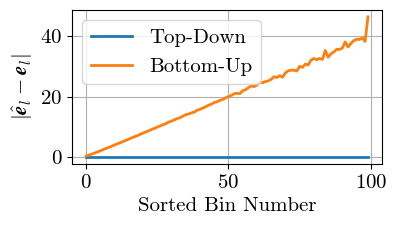

In [6]:
top_randomised_model = randomise_model_layers(model, toprand_layer, "top_down")
bottom_randomised_model = randomise_model_layers(model, bottomrand_layer, "bottom_up")

n_samples = len(loader.dataset.samples)
n_bins = 100

tmp = np.linspace(0, 1, n_bins)
xcounts = np.zeros_like(tmp)
yvals_topdown = np.zeros_like(tmp)
yvals_bottomup = np.zeros_like(tmp)

for i, (batch, labels) in enumerate(loader):

    x_batch = batch.numpy()
    y_batch = labels.numpy()

    baseline_explanations = explain_activation(
        model=model,
        inputs=x_batch,
        layer_name=layer_name,
        **XAI_METHOD_KWARGS[xai_method],
    )
    baseline_explanations = quantus.normalise_by_average_second_moment_estimate(baseline_explanations, normalise_axes=(1, 2, 3))
    baseline_explanations = np.abs(baseline_explanations)

    topdown_explanations = explain_activation(
        model=top_randomised_model,
        inputs=x_batch,
        layer_name=layer_name,
        **XAI_METHOD_KWARGS[xai_method],
    )
    topdown_explanations = quantus.normalise_by_average_second_moment_estimate(topdown_explanations, normalise_axes=(1, 2, 3))
    topdown_explanations = np.abs(topdown_explanations)

    bottomup_explanations = explain_activation(
        model=bottom_randomised_model,
        inputs=x_batch,
        layer_name=layer_name,
        **XAI_METHOD_KWARGS[xai_method],
    )
    bottomup_explanations = quantus.normalise_by_average_second_moment_estimate(bottomup_explanations, normalise_axes=(1, 2, 3))
    bottomup_explanations = np.abs(bottomup_explanations)

    for base, top, bot in list(zip(baseline_explanations, topdown_explanations, bottomup_explanations)):
        counthist, _ = np.histogram(base.flatten(), bins=n_bins)
        xcounts += counthist

        tophist, _ = np.histogram(base.flatten(), bins=n_bins, weights=np.abs(top-base).flatten())
        yvals_topdown += tophist

        bottomhist, _ = np.histogram(base.flatten(), bins=n_bins, weights=np.abs(bot-base).flatten())
        yvals_bottomup += bottomhist

yvals_topdown /= xcounts
yvals_bottomup /= xcounts

fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(yvals_topdown, linewidth=2, label="Top-Down")
ax.plot(yvals_bottomup, linewidth=2, label="Bottom-Up")

#ax.set_xlim(0, 1)
ax.set_xlabel("Sorted Bin Number")
ax.set_ylabel(r"$|\hat{\boldsymbol{e}}_l-\boldsymbol{e}_l|$")

ax.grid(True)

plt.legend()
fig.savefig(os.path.join(savepath, f"layerorder-{model_name}-{layer_name}-{toprand_layer}-{bottomrand_layer}-secondmomentnorm.svg"))

plt.show()

### 